### Importing the modules

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings("ignore")

### Preparing the data

In [43]:
diamonds = sns.load_dataset("diamonds")
diamonds_preprocessed = diamonds.copy(deep=True)

# Extract the columns and cast into category
cats = diamonds.select_dtypes(exclude=np.number).columns
for col in cats:
    diamonds_preprocessed[col] = diamonds_preprocessed[col].astype("category")

### Splitting the data into four sets

In [73]:
def split_into_four(df, train_size=0.7, random_state=1):
    """
    A function to split a dataset into four sets:
    - Training
    - Validation
    - Testing
    - Production
    train_size is set by the user.
    The remaining data will be equally divided between the three sets.
    """

    training, the_rest = train_test_split(df, train_size=train_size, random_state=1)
    validation, the_rest = train_test_split(the_rest, train_size=1 / 3, random_state=1)
    testing, production = train_test_split(the_rest, train_size=0.5, random_state=1)

    # Reset indices
    sets = (training, validation, testing, production)
    for set in sets:
        set.reset_index(inplace=True, drop=True)

    return sets


tr, val, test, prod = split_into_four(diamonds_preprocessed)

### Introduce artificial drifts

In [74]:
# Calculate the starting point for drift to affect 5-6 chunks of size 250
chunk_size = 250
num_chunks_drift = 5  # Adjust this to 6 if you want six chunks to drift
start_index_for_drift = len(prod) - (chunk_size * num_chunks_drift)

# Intensify drift in a numerical feature, 'depth'
# Assuming an increase in 'depth' values can simulate realistic drift
prod.loc[start_index_for_drift:, "depth"] *= 1.15  # Increasing depth by 15%

# Introduce noticeable drift in a categorical feature, 'color'
# Assuming 'color' has categories ['D', 'E', 'F', 'G', 'H', 'I', 'J']
# We will artificially increase the frequency of lower quality colors 'I' and 'J' in the drifting chunks
color_categories_to_increase = ["I", "J"]
prod.loc[start_index_for_drift:, "color"] = np.where(
    np.random.rand(len(prod) - start_index_for_drift)
    < 0.3,  # 30% chance to change to 'I' or 'J'
    np.random.choice(
        color_categories_to_increase, size=len(prod) - start_index_for_drift
    ),
    prod.loc[start_index_for_drift:, "color"],
)

# This modification increases the intensity of drift for both a numerical and a categorical feature,
# aiming to make the drift more detectable in analysis. Adjusting the percentage increase and the
# selection chance allows for control over the drift's visibility in your NannyML analysis.

In [75]:
to_concat = [tr, val, test, prod]
set_name = ["train", "val", "test", "prod"]

for df, label in zip(to_concat, set_name):
    df["set"] = label

In [76]:
final_df = pd.concat(to_concat)

In [77]:
final_df.to_csv("diamonds_special.csv", index=False)

### Defining features and target

In [78]:
all_feature_names = diamonds_preprocessed.drop("price", axis=1).columns.tolist()
numeric_feature_names = diamonds_preprocessed.select_dtypes(include=np.number).columns
numeric_feature_names = numeric_feature_names.tolist()

target = "price"

### Building a model

In [79]:
# Define the DMatrix for training and validation
dtrain = xgb.DMatrix(tr[all_feature_names], label=tr[target], enable_categorical=True)
dval = xgb.DMatrix(val[all_feature_names], label=val[target], enable_categorical=True)

In [80]:
# Define optimized parameters
params = {
    "n_estimators": 10000,
    "learning_rate": 0.1,
    "tree_method": "gpu_hist",
    "max_depth": 6,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "reg_alpha": 0.01,
    "reg_lambda": 1,
}

# Training with early stopping
regressor = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=[(dtrain, "train"), (dval, "eval")],
    early_stopping_rounds=50,
    verbose_eval=500,
)

[0]	train-rmse:3638.77217	eval-rmse:3581.88180
[178]	train-rmse:398.70234	eval-rmse:526.31089


In [81]:
# Define the DMatrix for testing and production
dtest = xgb.DMatrix(
    test[all_feature_names], label=test[target], enable_categorical=True
)
dprod = xgb.DMatrix(
    prod[all_feature_names], label=prod[target], enable_categorical=True
)

In [82]:
from sklearn.metrics import mean_squared_error

# Predict on the test set
y_test_pred = regressor.predict(dtest)

# Evaluate
mean_squared_error(test[target], y_test_pred, squared=False)

526.5131946801148

### Creating a reference set

In [83]:
reference = test.copy()
reference["y_pred"] = y_test_pred

reference[["price", "y_pred"]].head()

,price,y_pred
0,1388,1481.901367
1,1832,2088.636719
2,8060,7833.992676
3,1808,1824.474609
4,2111,2018.656372


### Creating an analysis set

In [84]:
# Deploy the model
y_prod_pred = regressor.predict(dprod)

analysis = prod.copy()
analysis["y_pred"] = y_prod_pred

analysis[["price", "y_pred"]].head()

,price,y_pred
0,687,753.692139
1,3823,3745.957031
2,544,583.499023
3,544,556.340576
4,1948,1981.163696


### Estimating performance with DLE

In [85]:
import nannyml

estimator = nannyml.DLE(
    feature_column_names=all_feature_names,
    y_true=target,
    y_pred="y_pred",
    metrics=["rmse"],
    chunk_size=250,
)

In [86]:
# Fit to the reference set
estimator.fit(reference)

# Estimate on the analysis set
estimated_results = estimator.estimate(analysis)

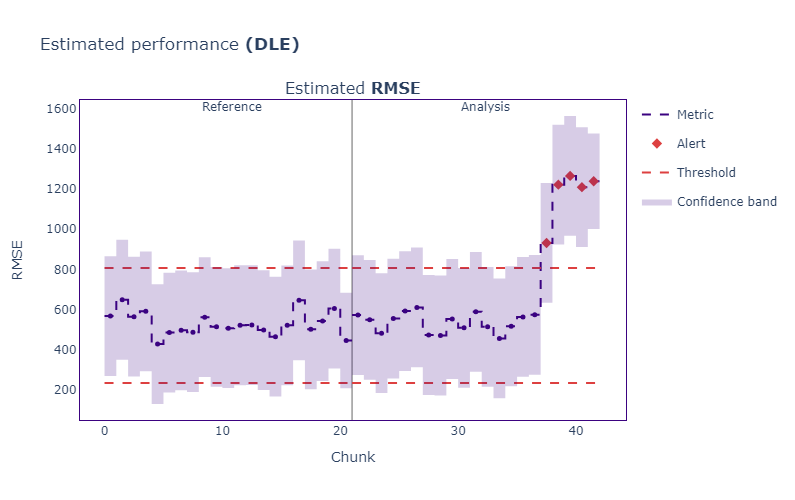

In [87]:
estimated_results.plot().show()

In [88]:
estimated_results.to_df().head()

chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0      [0:249]           0           0       249       None     None   
1    [250:499]           1         250       499       None     None   
2    [500:749]           2         500       749       None     None   
3    [750:999]           3         750       999       None     None   
4  [1000:1249]           4        1000      1249       None     None   

                       rmse                                                    \
      period sampling_error    realized       value upper_confidence_boundary   
0  reference      99.357668  616.653209  567.595667                865.668672   
1  reference      99.357668  666.111476  648.894486                946.967491   
2  reference      99.357668  569.264836  564.681194                862.754199   
3  reference      99.357668  590.023921  591.481304                889.554309   
4  reference      99.357668  372.993464  428.166806                726.239811   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                269.522663      806.923566      234.318833  False  
1                350.821481      806.923566      234.318833  False  
2                266.608189      806.923566      234.318833  False  
3                293.408299      806.923566      234.318833  False  
4                130.093802      806.923566      234.318833  False

Important columsn: chunk index, period, alert

In [89]:
estimated_results.filter(period="analysis").to_df().head()

chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0      [0:249]           0           0       249       None     None   
1    [250:499]           1         250       499       None     None   
2    [500:749]           2         500       749       None     None   
3    [750:999]           3         750       999       None     None   
4  [1000:1249]           4        1000      1249       None     None   

                      rmse                                                    \
     period sampling_error    realized       value upper_confidence_boundary   
0  analysis      99.357668  497.278867  572.708634                870.781639   
1  analysis      99.357668  461.399790  549.175604                847.248609   
2  analysis      99.357668  500.822399  482.590526                780.663531   
3  analysis      99.357668  531.479980  555.074563                853.147568   
4  analysis      99.357668  514.701961  592.394895                890.467900   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                274.635630      806.923566      234.318833  False  
1                251.102600      806.923566      234.318833  False  
2                184.517521      806.923566      234.318833  False  
3                257.001558      806.923566      234.318833  False  
4                294.321890      806.923566      234.318833  False

In [90]:
estimated_results.filter(metrics=["rmse"]).to_df().head()

chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0      [0:249]           0           0       249       None     None   
1    [250:499]           1         250       499       None     None   
2    [500:749]           2         500       749       None     None   
3    [750:999]           3         750       999       None     None   
4  [1000:1249]           4        1000      1249       None     None   

                       rmse                                                    \
      period sampling_error    realized       value upper_confidence_boundary   
0  reference      99.357668  616.653209  567.595667                865.668672   
1  reference      99.357668  666.111476  648.894486                946.967491   
2  reference      99.357668  569.264836  564.681194                862.754199   
3  reference      99.357668  590.023921  591.481304                889.554309   
4  reference      99.357668  372.993464  428.166806                726.239811   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                269.522663      806.923566      234.318833  False  
1                350.821481      806.923566      234.318833  False  
2                266.608189      806.923566      234.318833  False  
3                293.408299      806.923566      234.318833  False  
4                130.093802      806.923566      234.318833  False

### Calculating realized performance

In [91]:
calculator = nannyml.PerformanceCalculator(
    problem_type="regression",
    y_true=target,
    y_pred="y_pred",
    metrics=["rmse"],
    chunk_size=250,
)

calculator.fit(reference)
realized_results = calculator.calculate(analysis)

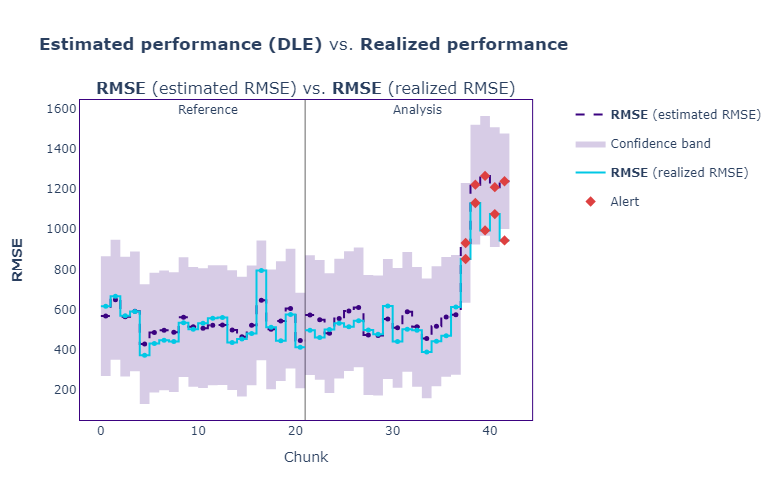

In [92]:
estimated_results.compare(realized_results).plot().show()

### Drift detection methods

### Multivariate drift detection

In [93]:
multivariate_calc = nannyml.DataReconstructionDriftCalculator(
    column_names=all_feature_names,
    chunk_size=250,
)

multivariate_calc.fit(reference)
multivariate_results = multivariate_calc.calculate(analysis)

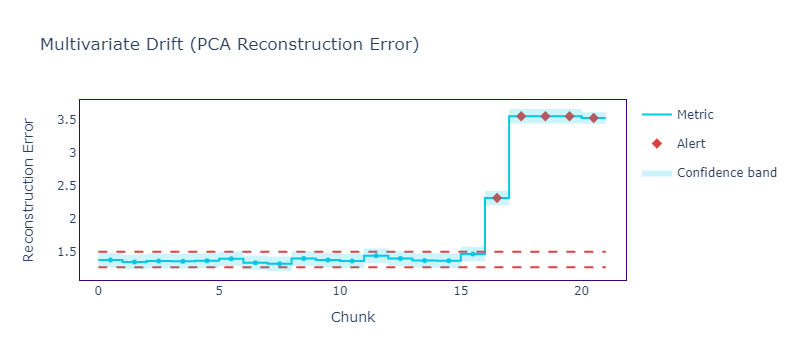

In [94]:
multivariate_results.filter(period="analysis").plot().show()

### Multivariate rec + realized performace

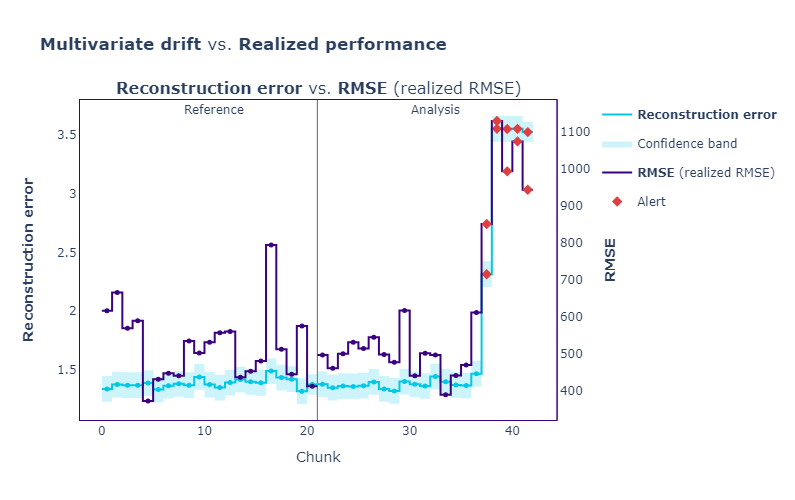

In [95]:
multivariate_results.compare(realized_results).plot().show()

### Univariate drift detection

In [96]:
univariate_calc = nannyml.UnivariateDriftCalculator(
    column_names=all_feature_names,
    continuous_methods=["wasserstein"],
    categorical_methods=["jensen_shannon"],
    chunk_size=250,
)

univariate_calc.fit(reference)
univariate_results = univariate_calc.calculate(analysis)

### Using an alert count ranker

In [99]:
alert_count_ranker = nannyml.AlertCountRanker()
filtered_univariate = univariate_results.filter(
    continuous_methods=["wasserstein"],
    categorical_methods=["jensen_shannon"],
    only_drifting=False,
)

ranker_results = alert_count_ranker.rank(filtered_univariate)

In [100]:
ranker_results.head(7)

,number_of_alerts,column_name,rank
0,7,color,1
1,5,depth,2
2,5,clarity,3
3,0,z,4
4,0,y,5
5,0,x,6
6,0,table,7
